In [23]:
from PIL import Image, ImageFilter, ImageOps
from IPython.display import display
import numpy as np
import requests

def get_image_from_url(url):
    im = Image.open(requests.get(url, stream=True).raw)
    display(im)
    return im

def resize_based_on_width(im, basewidth = 100):
    wpercent = (basewidth / float(im.size[0]))
    hsize = int((float(im.size[1]) * float(wpercent)))
    im = im.resize((basewidth, hsize))
    return im

def preprocess(im):
    im = resize_based_on_width(im)
    im = im.quantize(5)
    im = im.convert("L")
    im = im.filter(ImageFilter.FIND_EDGES)
    im = ImageOps.invert(im)
    im = im.point( lambda p: 255 if p > 230 else 0 )
    im = im.convert('1')
    a = np.asarray(im)
    display(im)
    return a

def make_line(a, gap, target_color):
    dotted_line = []
    head = None
    for i in range(len(a) - 1):
        if head is None and a[i] == target_color:
            head = i
        if head is not None and a[i + 1] != target_color:
            tail = i
            dotted_line += [(head * gap, (tail + 1) * gap)]
            head = None
        if i == len(a) - 2 and a[i + 1] == target_color:
            if head is None:
                head = i + 1
            tail = i + 1
            dotted_line += [(head * gap, (tail + 1) * gap)]
    return dotted_line


def make_lines(a, gap=1, target_color=False):
    dotted_lines = []
    for a_ in a:
        dotted_lines += [make_line(a_, gap, target_color)]
    return dotted_lines
  
def image_to_lines(path='', url=None):
    if url is not None:
        im = get_image_from_url(url)
    else:
        im = Image.open(path)
    print('原圖：')
    display(im)
    print('處理後：')
    a = preprocess(im)
    lines = make_lines(a)
    return lines

In [24]:
from selenium.webdriver.common.action_chains import ActionChains

def draw(driver, elem, lines, xoffset=10, yoffset=10, gap=1, line_height=None):
    if line_height is None:
        line_height = gap

    action = ActionChains(driver)
    action.w3c_actions.pointer_action._duration = 1
    for i, line in enumerate(lines):
        # print(line)
        for seg in line:
            action.move_to_element_with_offset(
                elem, xoffset + seg[0] * gap, yoffset + i * line_height
            )
            action.click_and_hold()
            action.move_to_element_with_offset(
                elem, xoffset + seg[1] * gap, yoffset + i * line_height
            )
            action.release()
    action.perform()

In [25]:
# 啟動 Chrome 必須先下載 Chrome 驅動器(https://sites.google.com/chromium.org/driver/)
# 將 Chrome 驅動器放置同路徑下，或設定於系統環境變數中的 Path
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from base64 import b64decode

options = Options()
options.add_extension("uBlock-Origin.crx")
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get("https://gartic.io/")

print("Chrome Browser Invoked")


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [C:\Users\Asus\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache
C:\Users\Asus\AppData\Local\Temp\ipykernel_19060\4139287074.py:14: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


Chrome Browser Invoked


In [32]:
# 找出題目
from bs4 import BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')
titles = soup.find("div", class_="word")
keyword = titles.text
print('題目:', keyword)

無人駕駛飛機


In [33]:
# 開啟新分頁(圖片搜尋頁面)
google_image_url = (
    "https://images.google.com"  # step1: setup url1 you want to visit in new page
)
strScript = 'window.open("' + google_image_url + '");'
driver.execute_script(strScript)
driver.switch_to.window(driver.window_handles[1])
driver.find_element(By.CLASS_NAME, "gLFyf.gsfi").send_keys("cat",Keys.ENTER)


C:\Users\Asus\AppData\Local\Temp\ipykernel_19060\2468387551.py:6: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  driver.find_element_by_class_name("gLFyf.gsfi").send_keys(titles.text)
C:\Users\Asus\AppData\Local\Temp\ipykernel_19060\2468387551.py:7: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  driver.find_element_by_class_name("Tg7LZd").click()


In [34]:
driver.find_element(By.XPATH, '/html/body/div[2]/c-wiz/div[3]/div[1]/div/div/div/div[1]/div[1]/span/div[1]/div[1]/div[1]').click()
image_src = driver.find_element(By.XPATH, '/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[3]/div/a/img').get_attribute('src')

soup2 = BeautifulSoup(driver.page_source, 'html.parser')
temp = soup2.find_all('img')
# temp[3]以前都怪怪的，3以後都可以
header, encoded = temp[35]["src"].split(",", 1)
data = b64decode(encoded)

with open("image.jpg", "wb") as f:
    f.write(data)

# 切回原本頁面(遊戲頁面)
driver.switch_to.window(driver.window_handles[0])

In [35]:
wait = WebDriverWait(driver, 10)
elem = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "canvas")))

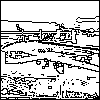

In [36]:
if elem:
  lines = image_to_lines(path="image.jpg")
  draw(driver=driver, elem=elem, lines=lines, gap=3)